[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/self_querying_agent_mongodb_unstructured.ipynb)

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://www.mongodb.com/developer/products/atlas/advanced-rag-metadata-filtering/?utm_campaign=devrel&utm_source=cross-post&utm_medium=organic_social&utm_content=https%3A%2F%2Fgithub.com%2Fmongodb-developer%2FGenAI-Showcase&utm_term=apoorva.joshi)

# Advanced RAG: Metadata Extraction and Self-Querying Retrieval

This notebook shows how to incorporate metadata filtering and self-querying retrieval into a RAG application using Unstructured, MongoDB and LangGraph.

## Step 1: Install required libraries

- **langgraph**: Python package to build stateful, multi-actor applications with LLMs
<p>
- **openai**: Python package to interact with OpenAI APIs
<p>
- **pymongo**: Python package to interact with MongoDB databases and collections
<p>
- **sentence-transformers**: Python package for open-source language models
<p>
- **unstructured-ingest**: Python package for data processing using Unstructured

In [1]:
!pip install -qU langgraph openai pymongo sentence-transformers "unstructured-ingest[pdf, s3, mongodb, embed-huggingface]"


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Step 2: Setup prerequisites

- **Set the Unstructured API key and URL**: Steps to obtain the API key and URL are [here](TBD)

- **Set the AWS access keys**: Steps to obtain the AWS access keys are [here](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_access-keys.html)

- **Set the MongoDB connection string**: Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

- **Set the OpenAI API key**: Steps to obtain an API key as [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)

In [4]:
import os
from openai import OpenAI
from pymongo import MongoClient

In [ ]:
# Your Unstructured API key and URL
UNSTRUCTURED_API_KEY = ""
UNSTRUCTURED_URL = ""

In [ ]:
# Your AWS authentication credentials
AWS_KEY = ""
AWS_SECRET = ""

In [ ]:
# S3 URI for the Access Point to the bucket with PDF files
AWS_S3_NAME = ""

In [5]:
# Your MongoDB connection string (uri), and collection/database names
MONGODB_URI = ""
MONGODB_DB_NAME = ""
MONGODB_COLLECTION = ""
# Instantiate the MongoDB client
mongodb_client = MongoClient(
    MONGODB_URI, appname="devrel.content.selfquery_mongodb_unstructured"
)

In [6]:
# Your OpenAI API key
os.environ["OPENAI_API_KEY"] = ""
# Instantiate the OpenAI client
openai_client = OpenAI()

In [ ]:
# Embedding model to use
EMBEDDING_MODEL_NAME = "BAAI/bge-base-en-v1.5"

In [ ]:
## Completion model to use
COMPLETION_MODEL_NAME = "gpt-4o-2024-08-06"

## Step 3: Partition, chunk and embed PDF files from S3

Let's set up the PDF preprocessing pipeline with Unstructured. The pipeline will:
1. Ingest data from an S3 bucket
2. Partition documents: extract text and metadata, split the documents into document elements, such as titles, paragraphs (narrative text), tables, images, lists, etc. Learn more about document elements in [Unstructured documentation])https://docs.unstructured.io/api-reference/api-services/document-elements).
3. Chunk the documents.
4. Embed the documents with the [`BAAI/bge-base-en-v1.5`](https://huggingface.co/BAAI/bge-base-en-v1.5) embedding model the Hugging Face Hub.
5. Save the results locally.

In [ ]:
from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig
from unstructured_ingest.v2.processes.chunker import ChunkerConfig
from unstructured_ingest.v2.processes.embedder import EmbedderConfig
from unstructured_ingest.v2.processes.connectors.fsspec.s3 import (
    S3ConnectionConfig,
    S3DownloaderConfig,
    S3IndexerConfig,
    S3AccessConfig,
)
from unstructured_ingest.v2.processes.connectors.local import LocalUploaderConfig

In [ ]:
work_dir = "/content/temp"

In [ ]:
Pipeline.from_configs(
    context=ProcessorConfig(
        verbose=True, tqdm=True, num_processes=5, work_dir=work_dir
    ),
    indexer_config=S3IndexerConfig(remote_url=AWS_S3_NAME),
    downloader_config=S3DownloaderConfig(),
    source_connection_config=S3ConnectionConfig(
        access_config=S3AccessConfig(key=AWS_KEY, secret=AWS_SECRET)
    ),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=UNSTRUCTURED_API_KEY,
        partition_endpoint=UNSTRUCTURED_URL,
        strategy="hi_res",
        additional_partition_args={
            "split_pdf_page": True,
            "split_pdf_allow_failed": True,
            "split_pdf_concurrency_level": 15,
        },
    ),
    chunker_config=ChunkerConfig(
        chunking_strategy="by_title",
        chunk_max_characters=1500,
        chunk_overlap=150,
    ),
    embedder_config=EmbedderConfig(
        embedding_provider="langchain-huggingface",
        embedding_model_name="BAAI/bge-base-en-v1.5",
    ),
    uploader_config=LocalUploaderConfig(output_dir="/content/ingest-outputs"),
).run()

## Step 4: Add custom metadata to the processed documents

For each document, we want to add the company name and fiscal year as custom metadata, to enable smart pre-filtering for more precise document retrieval.

Luckily the Form-10K documents have a more or less standard page with this information, so we can use regex to extract this information.

In [7]:
import re
import json

In [ ]:
def get_fiscal_year(elements: dict) -> str:
    # Regular expression pattern to find the element containing the fiscal year
    pattern = r"for the (fiscal\s+)?year ended.*?(\d{4})"
    year = ""
    for i in range(len(elements)):
        match = re.search(pattern, elements[i]["text"], re.IGNORECASE)
        if match:
            return match.group(0)[-4:]
    return year


def get_company_name(elements: dict) -> str:
    name = ""
    # In most cases the name of the company is right before/above the following line
    substring = "(Exact name of registrant as specified"
    for i in range(len(elements)):
        if substring.lower() in elements[i]["text"].lower():
            pattern = (
                r"([A-Z][A-Za-z\s&.,]+?)\s*\(Exact name of registrant as specified"
            )
            match = re.search(pattern, elements[i]["text"], re.IGNORECASE)
            if match:
                name = match.group(1).strip()
                name = name.split("\n\n")[-1]

    if name == "":
        for i in range(len(elements)):
            # In some cases, the name of the company is right after/below the following line
            match = re.search(
                r"Exact name of registrant as specified in its charter:\n\n(.*?)\n\n",
                elements[i]["text"],
            )
            if match:
                name = match.group(1)
            else:
                # In other cases, the name follows the "Commission File Number [Number]" line
                match = re.search(
                    r"Commission File Number.*\n\n(.*?)\n\n", elements[i]["text"]
                )
                if match:
                    name = match.group(1)
    return name

We'll walk through the directory with the embedding results, and for each document find the company name and year, and add it as custom metadata to all elements of the document.

In [ ]:
def add_custom_metadata_to_json_outputs(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            print(f"Processing file {filename}")
            try:
                with open(file_path, "r") as file:
                    data = json.load(file)

                company_name = get_company_name(data)
                fiscal_year = get_fiscal_year(data)

                # Add custom metadata fields to each entry
                for entry in data:
                    entry["metadata"]["custom_metadata"] = {}
                    entry["metadata"]["custom_metadata"]["company"] = company_name
                    entry["metadata"]["custom_metadata"]["year"] = fiscal_year

                with open(file_path, "w") as file:
                    json.dump(data, file, indent=2)

                print(f"Successfully updated {file_path} with custom metadata fields.")
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON in {file_path}: {e}")
            except IOError as e:
                print(f"Error reading from or writing to {file_path}: {e}")

In [ ]:
add_custom_metadata_to_json_outputs(f"{work_dir}/embed")

## Step 5: Write the results to MongoDB

To write the results to MongoDB, we will need to rerun the same pipeline, except we'll now change the destination from local to MongoDB.
The pipeline will not repeat partitioning, chunking and embedding steps, since there are results for them already cached in the `work_dir`. It will pick up the customized embedding results and load them into a MongoDB collection.



In [ ]:
from unstructured_ingest.v2.processes.connectors.mongodb import (
    MongoDBConnectionConfig,
    MongoDBUploadStagerConfig,
    MongoDBUploaderConfig,
    MongoDBAccessConfig,
)

In [ ]:
Pipeline.from_configs(
    context=ProcessorConfig(
        verbose=True, tqdm=True, num_processes=5, work_dir=work_dir
    ),
    indexer_config=S3IndexerConfig(remote_url=AWS_S3_NAME),
    downloader_config=S3DownloaderConfig(),
    source_connection_config=S3ConnectionConfig(
        access_config=S3AccessConfig(key=AWS_KEY, secret=AWS_SECRET)
    ),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=UNSTRUCTURED_API_KEY,
        partition_endpoint=UNSTRUCTURED_URL,
        strategy="hi_res",
        additional_partition_args={
            "split_pdf_page": True,
            "split_pdf_allow_failed": True,
            "split_pdf_concurrency_level": 15,
        },
    ),
    chunker_config=ChunkerConfig(
        chunking_strategy="by_title",
        chunk_max_characters=1500,
        chunk_overlap=150,
    ),
    embedder_config=EmbedderConfig(
        embedding_provider="langchain-huggingface",
        embedding_model_name=EMBEDDING_MODEL_NAME,
    ),
    destination_connection_config=MongoDBConnectionConfig(
        access_config=MongoDBAccessConfig(uri=MONGODB_URI),
        collection=MONGODB_COLLECTION,
        database=MONGODB_DB_NAME,
    ),
    stager_config=MongoDBUploadStagerConfig(),
    uploader_config=MongoDBUploaderConfig(batch_size=100),
).run()

Next, we are going to use LangGraph to build our investment assistant. With LangGraph, we can build LLM systems as graphs with a shared state, conditional edges, and cyclic loops between nodes.

## Step 6: Define graph state

Let's first define the state of our graph. The state is a mutable object that tracks different attributes as we pass through the nodes in the graph. We can include custom attributes within the state that represent parameters we want to track.

In [10]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List, Dict

In [11]:
class GraphState(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        question: User query
        metadata: Extracted metadata
        filter: MQL filter definition
        documents: List of retrieved documents from vector search
        memory: Conversational history 
    """

    question: str
    metadata: Dict
    filter: Dict
    context: List[str]
    memory: Annotated[list, add_messages]

## Step 7: Define graph nodes

Next, let's add the graph nodes. Nodes in LangGraph are functions or tools that your system has access to in order to complete the task. Each node updates one or more attributes in the graph state with its return value after it executes. Our assistant has four nodes:
1. **Metadata Extractor**: Extract metadata from a natural language query
2. **MQL Filter Generator**: Generate a MongoDB query filter definition
3. **MongoDB Atlas Vector Search**: Retrieve documents from MongoDB using semantic search
4. **Answer Generator**: Generate an answer to the user question




### Metadata Extractor

In [12]:
from pydantic import BaseModel, Field
from datetime import datetime

In [13]:
companies = [
    "AT&T INC.",
    "American International Group, Inc.",
    "Apple Inc.",
    "BERKSHIRE HATHAWAY INC.",
    "Bank of America Corporation",
    "CENCORA, INC.",
    "CVS HEALTH CORPORATION",
    "Cardinal Health, Inc.",
    "Chevron Corporation",
    "Citigroup Inc.",
    "Costco Wholesale Corporation",
    "Exxon Mobil Corporation",
    "Ford Motor Company",
    "GENERAL ELECTRIC COMPANY",
    "GENERAL MOTORS COMPANY",
    "HP Inc.",
    "INTERNATIONAL BUSINESS MACHINES CORPORATION",
    "JPMorgan Chase & Co.",
    "MICROSOFT CORPORATION",
    "MIDLAND COMPANY",
    "McKESSON CORPORATION",
    "THE BOEING COMPANY",
    "THE HOME DEPOT, INC.",
    "THE KROGER CO.",
    "The Goldman Sachs Group, Inc.",
    "UnitedHealth Group Incorporated",
    "VALERO ENERGY CORPORATION",
    "Verizon Communications Inc.",
    "WALMART INC.",
    "WELLS FARGO & COMPANY",
]

In [14]:
class Metadata(BaseModel):
    """Metadata to use for pre-filtering."""

    company: List[str] = Field(description="List of company names")
    year: List[str] = Field(description="List containing start year and end year")

In [15]:
def extract_metadata(state: Dict) -> Dict:
    """
    Extract metadata from natural language query.

    Args:
        state (Dict): The current graph state

    Returns:
        Dict: New key added to state i.e. metadata containing the metadata extracted from the user query.
    """
    print("---EXTRACTING METADATA---")
    question = state["question"]
    system = f"""Extract the specified metadata from the user question:
    - company: List of company names, eg: Google, Adobe etc. Match the names to companies on this list: {companies}
    - year: List of [start year, end year]. Guidelines for extracting dates:
        - If a single date is found, only include that.
        - For phrases like 'in the past X years/last year', extract the start year by subtracting X from the current year. The current year is {datetime.now().year}.
        - If more than two dates are found, only include the smallest and the largest year."""
    completion = openai_client.beta.chat.completions.parse(
        model=COMPLETION_MODEL_NAME,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": question},
        ],
        response_format=Metadata,
    )
    result = completion.choices[0].message.parsed
    # If no metadata is extracted return an empty dictionary
    if len(result.company) == 0 and len(result.year) == 0:
        return {"metadata": {}}
    metadata = {
        "metadata.custom_metadata.company": result.company,
        "metadata.custom_metadata.year": result.year,
    }
    return {"metadata": metadata}

### MQL Filter Generator

In [16]:
def generate_mql_filter(state: Dict) -> Dict:
    """
    Generate MongoDB Query Language (MQL) filter definition.

    Args:
        state (Dict): The current graph state

    Returns:
        Dict: New key added to state i.e. filter containing the MQL filter.
    """
    print("---GENERATING FILTER DEFINITION---")
    metadata = state["metadata"]
    system = """Generate a MongoDB filter definition from the provided fields. Follow the guidelines below:
    - Respond in JSON with the filter assigned to a `filter` key.
    - The field `metadata.custom_metadata.company` is a list of companies.
    - The field `metadata.custom_metadata.year` is a list of one or more years.
    - If any of the provided fields are empty lists, DO NOT include them in the filter.
    - If both the metadata fields are empty lists, return an empty dictionary {{}}.
    - The filter should only contain the fields `metadata.custom_metadata.company` and `metadata.custom_metadata.year`
    - The filter can only contain the following MQL match expressions:
        - $gt: Greater than
        - $lt: Lesser than
        - $gte: Greater than or equal to
        - $lte: Less than or equal to
        - $eq: Equal to
        - $ne: Not equal to
        - $in: Specified field value equals any value in the specified array
        - $nin: Specified field value is not present in the specified array
        - $nor: Logical NOR operation
        - $and: Logical AND operation
        - $or: Logical OR operation
    - If the `metadata.custom_metadata.year` field has multiple dates, create a date range filter using expressions such as $gt, $lt, $lte and $gte
    - If the `metadata.custom_metadata.company` field contains a single company, use the $eq expression
    - If the `metadata.custom_metadata.company` field contains multiple companies, use the $in expression
    - To combine date range and company filters, use the $and operator
    """
    completion = openai_client.chat.completions.create(
        model=COMPLETION_MODEL_NAME,
        temperature=0,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": f"Fields: {metadata}"},
        ],
        response_format={"type": "json_object"},
    )
    result = json.loads(completion.choices[0].message.content)
    return {"filter": result.get("filter", {})}

### MongoDB Atlas Vector Search

To perform vector search, first [create a vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/) with the following index definition:

```
{
  "fields": [
    {
      "type": "vector",
      "path": "embeddings",
      "numDimensions": 768,
      "similarity": "cosine"
    },
    {
      "type": "filter",
      "path": "metadata.custom_metadata.company"
    },
    {
      "type": "filter",
      "path": "metadata.custom_metadata.year"
    }
  ]
}
```

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)

In [19]:
collection = mongodb_client[MONGODB_DB_NAME][MONGODB_COLLECTION]

In [20]:
def vector_search(state: Dict) -> Dict:
    """
    Get relevant information using MongoDB Atlas Vector Search

    Args:
        state (Dict): The current graph state

    Returns:
        Dict: New key added to state i.e. documents.
    """
    print("---PERFORMING VECTOR SEARCH---")
    question = state["question"]
    filter = state["filter"]
    # We always want a valid filter object
    if not filter:
        filter = {}
    query_embedding = embedding_model.encode(question).tolist()
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "path": "embeddings",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
                "filter": filter,
            }
        },
        {
            "$project": {
                "_id": 0,
                "text": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]
    # Execute the aggregation pipeline
    results = collection.aggregate(pipeline)
    # Drop documents with cosine similarity score < 0.8
    relevant_results = [doc["text"] for doc in results if doc["score"] >= 0.8]
    context = "\n\n".join([doc for doc in relevant_results])
    return {"context": context}

### Answer Generator

In [21]:
from langchain_core.messages import HumanMessage, AIMessage

In [22]:
def generate_answer(state: Dict) -> Dict:
    """
    Generate the final answer to the user query

    Args:
        state (Dict): The current graph state

    Returns:
        Dict: New key added to state i.e. generation.
    """
    print("---GENERATING THE ANSWER---")
    question = state["question"]
    context = state["context"]
    memory = state["memory"]
    print(memory)
    system = f"Answer the question based only on the following context. If the context is empty or if it doesn't provide enough information to answer the question, say I DON'T KNOW"
    completion = openai_client.chat.completions.create(
        model=COMPLETION_MODEL_NAME,
        temperature=0,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": f"Context:\n{context}\n\n{memory}\n\nQuestion:{question}"},
        ],
    )
    answer = completion.choices[0].message.content
    return {"memory": [HumanMessage(content=context), AIMessage(content=answer)]}

## Step 8: Define conditional edges

Conditional edges in LangGraph decide which node in the graph to visit next. Here, we have a single conditional edge to skip filter generation and go directly to the vector search step if no metadata was extracted from the user query.

In [23]:
def check_metadata_extracted(state: Dict) -> str:
    """
    Check if any metadata is extracted.

    Args:
        state (Dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---CHECK FOR METADATA---")
    metadata = state["metadata"]
    # If no metadata is extracted, skip the generate filter step
    if not metadata:
        print("---DECISION: SKIP TO VECTOR SEARCH---")
        return "vector_search"
    # If metadata is extracted, generate MQL filter definition
    else:
        print("---DECISION: GENERATE MQL FILTER---")
        return "generate_mql_filter"

## Step 9: Build the graph/flow

This is where we actually define the flow of the graph by connecting nodes to edges.

In [24]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from pprint import pprint

In [25]:
workflow = StateGraph(GraphState)
# Adding memory to the graph
memory = MemorySaver()

In [26]:
# Add nodes
workflow.add_node("extract_metadata", extract_metadata)
workflow.add_node("generate_mql_filter", generate_mql_filter)
workflow.add_node("vector_search", vector_search)
workflow.add_node("generate_answer", generate_answer)

# Add edges
workflow.add_edge(START, "extract_metadata")
workflow.add_conditional_edges(
    "extract_metadata",
    check_metadata_extracted,
    {
        "vector_search": "vector_search",
        "generate_mql_filter": "generate_mql_filter",
    },
)
workflow.add_edge("generate_mql_filter", "vector_search")
workflow.add_edge("vector_search", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile the graph
app = workflow.compile(checkpointer=memory)

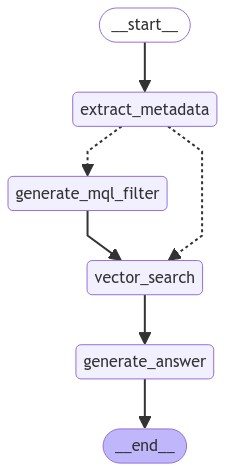

In [27]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Step 10: Execute the graph

In [28]:
def execute_graph(thread_id: str, question: str) -> None:
    """
    Execute the graph and stream its output

    Args:
        thread_id (str): Conversation thread ID
        question (str): User question
    """
    # Add question to the question and memory attributes of the graph state 
    inputs = {"question": question, "memory": [HumanMessage(content=question)]}
    config = {"configurable": {"thread_id": thread_id}}
    # Stream outputs as they come
    for output in app.stream(inputs, config):
        for key, value in output.items():
            pprint(f"Node {key}:")
            print(value)
    pprint("---FINAL ANSWER---")
    print(value["memory"][-1].content)

In [32]:
execute_graph("1", "Sales summary for Walmart for 2023.")

---EXTRACTING METADATA---
---CHECK FOR METADATA---
---DECISION: GENERATE MQL FILTER---
'Node extract_metadata:'
{'metadata': {'metadata.custom_metadata.company': ['WALMART INC.'], 'metadata.custom_metadata.year': ['2023']}}
---GENERATING FILTER DEFINITION---
'Node generate_mql_filter:'
{'filter': {'$and': [{'metadata.custom_metadata.company': {'$eq': 'WALMART INC.'}}, {'metadata.custom_metadata.year': {'$eq': 2023}}]}}
---PERFORMING VECTOR SEARCH---
'Node vector_search:'
{'context': 'DOCUMENTS INCORPORATED BY REFERENCE\n\nDocument Portions of the registrant\'s Proxy Statement for the Annual Meeting of Shareholders to be held May 31, 2023 (the "Proxy Statement")\n\nParts Into Which Incorporated Part III\n\nWalmart Inc. Form 10-K For the Fiscal Year Ended January 31, 2023\n\nTable of Contents\n\nWALMART INC. ANNUAL REPORT ON FORM 10-K FOR THE FISCAL YEAR ENDED JANUARY 31, 2023\n\nAll references in this Annual Report on Form 10-K, the information incorporated into this Annual Report on Fo

In [33]:
execute_graph("1", "What did I just ask you?")

---EXTRACTING METADATA---
---CHECK FOR METADATA---
---DECISION: SKIP TO VECTOR SEARCH---
'Node extract_metadata:'
{'metadata': {}}
---PERFORMING VECTOR SEARCH---
'Node vector_search:'
{'context': ''}
---GENERATING THE ANSWER---
[HumanMessage(content='Sales summary for Walmart for 2023.', id='3159a82d-249c-4e0c-bb7f-b3495375016c'), HumanMessage(content='DOCUMENTS INCORPORATED BY REFERENCE\n\nDocument Portions of the registrant\'s Proxy Statement for the Annual Meeting of Shareholders to be held May 31, 2023 (the "Proxy Statement")\n\nParts Into Which Incorporated Part III\n\nWalmart Inc. Form 10-K For the Fiscal Year Ended January 31, 2023\n\nTable of Contents\n\nWALMART INC. ANNUAL REPORT ON FORM 10-K FOR THE FISCAL YEAR ENDED JANUARY 31, 2023\n\nAll references in this Annual Report on Form 10-K, the information incorporated into this Annual Report on Form 10-K by reference to information in the Proxy Statement of Walmart Inc. for its Annual Shareholders\' Meeting to be held on May 31,

In [34]:
execute_graph("1", "What's my name?")

---EXTRACTING METADATA---
---CHECK FOR METADATA---
---DECISION: SKIP TO VECTOR SEARCH---
'Node extract_metadata:'
{'metadata': {}}
---PERFORMING VECTOR SEARCH---
'Node vector_search:'
{'context': ''}
---GENERATING THE ANSWER---
[HumanMessage(content='Sales summary for Walmart for 2023.', id='3159a82d-249c-4e0c-bb7f-b3495375016c'), HumanMessage(content='DOCUMENTS INCORPORATED BY REFERENCE\n\nDocument Portions of the registrant\'s Proxy Statement for the Annual Meeting of Shareholders to be held May 31, 2023 (the "Proxy Statement")\n\nParts Into Which Incorporated Part III\n\nWalmart Inc. Form 10-K For the Fiscal Year Ended January 31, 2023\n\nTable of Contents\n\nWALMART INC. ANNUAL REPORT ON FORM 10-K FOR THE FISCAL YEAR ENDED JANUARY 31, 2023\n\nAll references in this Annual Report on Form 10-K, the information incorporated into this Annual Report on Form 10-K by reference to information in the Proxy Statement of Walmart Inc. for its Annual Shareholders\' Meeting to be held on May 31,